# Churn Classifier Analytics & Modeling

The churn rate, also known as the rate of attrition or customer churn, is the rate at which customers stop doing business with an entity. 

## Loading libraries

In [1]:
# -*- coding: utf-8 -*-
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Loading data

In [2]:

file_path = os.getcwd() + '/Churn_Modelling.csv'

df = pd.read_csv(file_path)
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploratory data analysis

In [3]:
df.shape

(10000, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:

# data preprocessing
category_str_columns = ['Geography', 'Gender']
category_int_columns = [ 'Tenure', 'HasCrCard', 'IsActiveMember']
floating_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

target_column = ['Exited']


In [6]:
df[floating_columns].describe()

,CreditScore,Age,Balance,NumOfProducts,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,250898.090000,4.000000,199992.480000


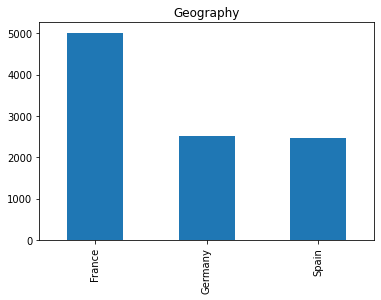

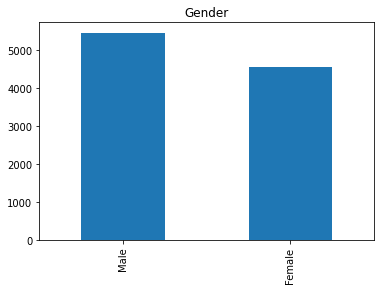

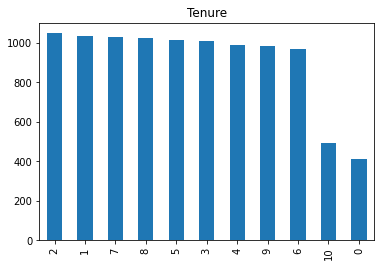

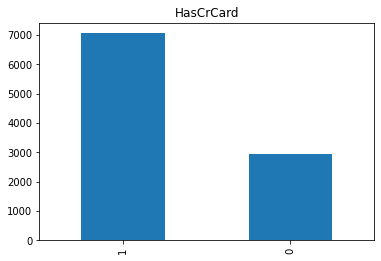

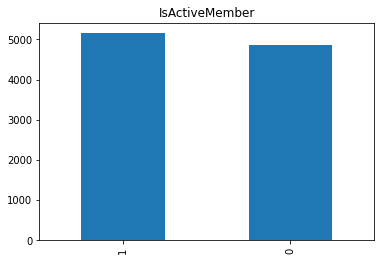

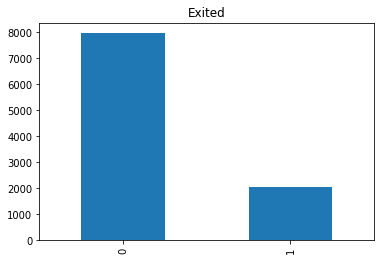

In [7]:
for i in category_str_columns+category_int_columns+target_column:
    df[i].value_counts().plot.bar(label=i, title=i)
    plt.show()
    

Imbalanced classes, I'll have to do a down sampling it seams.

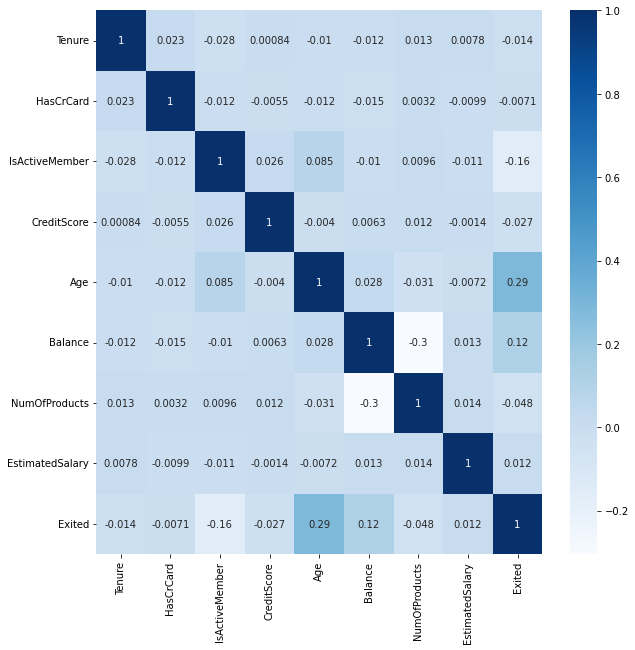

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
corr_values = df[category_str_columns + category_int_columns +\
                 floating_columns + target_column].corr(method='pearson')
sns.heatmap(corr_values, annot=True, ax=ax, cmap='Blues')
plt.show()


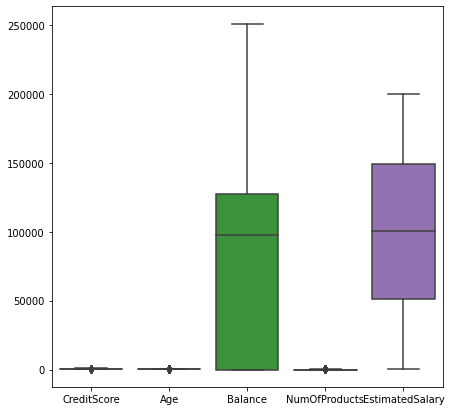

In [9]:
fig, ax=plt.subplots(1,1,figsize=(7,7))
sns.boxplot(data=df[floating_columns], ax=ax)
plt.show()

## downsampling to get balanced data

In [10]:
df = df[floating_columns+category_str_columns+category_int_columns+target_column]

In [11]:
df_0 = df[df.Exited == 0]
df_1 = df[df.Exited == 1]

print(df_0.shape, df_1.shape)

(7963, 11) (2037, 11)


In [12]:
df_0 = df_0.sample(df_1.shape[0])

In [13]:
bal_df = pd.concat([df_0,df_1]).sample(frac=1, random_state=10)
bal_df.head()

,CreditScore,Age,Balance,NumOfProducts,EstimatedSalary,Geography,Gender,Tenure,HasCrCard,IsActiveMember,Exited
9905,645,41,93925.30,1,123982.14,Germany,Male,2,1,0,1
7483,616,44,102016.38,1,178235.37,France,Male,5,0,1,1
1747,586,34,74309.81,1,15034.93,Germany,Male,9,1,0,0
5002,590,43,81076.80,2,182627.25,France,Male,7,1,1,1
9447,718,41,0.00,2,27509.52,France,Female,1,0,1,1


In [47]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

In [15]:
category_encoder = OneHotEncoder().fit(bal_df[category_str_columns])

In [16]:
floating_scaler = StandardScaler().fit(bal_df[category_int_columns + floating_columns])

In [17]:
encoded_data = np.hstack(
    (
        category_encoder.transform(bal_df[category_str_columns]).toarray(), 
        floating_scaler.transform(bal_df[category_int_columns + floating_columns])
    )
)

In [48]:
pca = PCA(n_components=5).fit(encoded_data)

In [50]:
ready_data = pca.transform(encoded_data)

In [51]:

x_train, x_test, y_train, y_test = train_test_split(
    ready_data, bal_df.Exited, test_size=0.1, random_state=10)

In [79]:
input_layer = tf.keras.layers.Input(shape=(x_train.shape[1],), name='Input-Layer')
relu_layer1 = tf.keras.layers.Dense(units=6, activation='relu', name='Relu-Layer-1')(input_layer)
relu_layer2 = tf.keras.layers.Dense(units=6, activation='relu', name='Relu-Layer-2')(relu_layer1)
relu_layer3 = tf.keras.layers.Dense(units=6, activation='relu', name='Relu-Layer-3')(relu_layer2)
output = tf.keras.layers.Dense(units=1, activation='sigmoid', name='Output-Layer')(relu_layer3)


model = tf.keras.Model(inputs=[input_layer], outputs=[output])

In [80]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 5)]               0         
                                                                 
 Relu-Layer-1 (Dense)        (None, 6)                 36        
                                                                 
 Relu-Layer-2 (Dense)        (None, 6)                 42        
                                                                 
 Relu-Layer-3 (Dense)        (None, 6)                 42        
                                                                 
 Output-Layer (Dense)        (None, 1)                 7         
                                                                 
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________


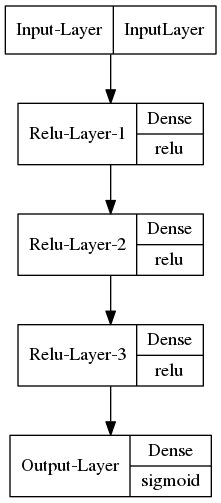

In [81]:
tf.keras.utils.plot_model(model,show_layer_activations=True)

In [82]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [83]:
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=500, validation_split=0.2, verbose=0)

In [84]:
history_df = pd.DataFrame(history.history)
history_df['epochs'] = history.epoch

/home/nishant/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/nishant/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/nishant/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/nishant/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:33

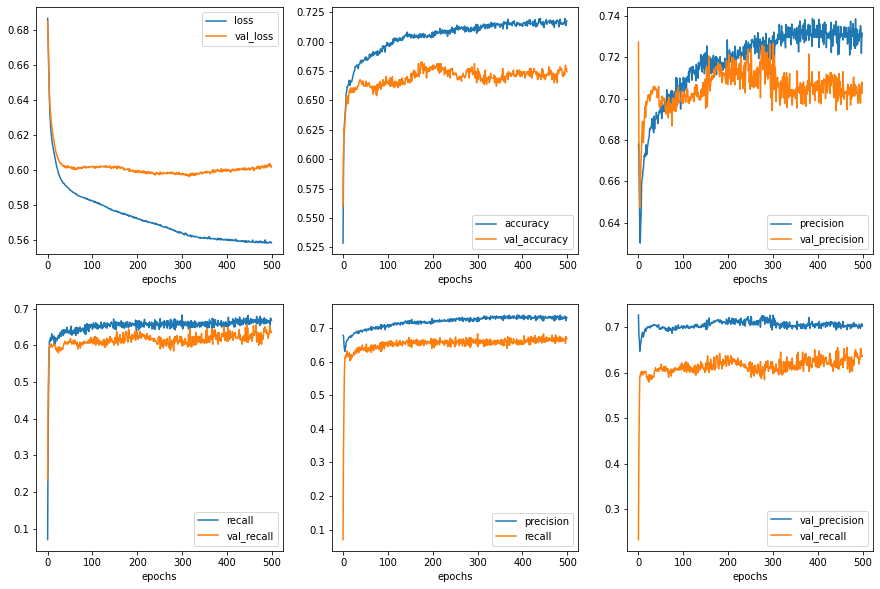

In [85]:

fig, ax = plt.subplots(2,3, figsize=(15,10))
history_df.plot(x='epochs', y=['loss', 'val_loss'], ax=ax[0][0])
history_df.plot(x='epochs', y=['accuracy', 'val_accuracy'], ax=ax[0][1])
history_df.plot(x='epochs', y=['precision','val_precision'], ax=ax[0][2])
history_df.plot(x='epochs', y=['recall','val_recall'], ax=ax[1][0])
history_df.plot(x='epochs', y=['precision','recall'], ax=ax[1][1])
history_df.plot(x='epochs', y=['val_precision','val_recall'], ax=ax[1][2])
plt.show()

In [95]:
y_pred = np.array(model.predict(x_test) > 0.4, dtype=np.int32)

In [96]:
accuracy_score(y_test, y_pred)

0.6519607843137255

In [97]:
confusion_matrix(y_test,y_pred)

array([[103,  81],
       [ 61, 163]])

In [98]:
confusion_matrix(y_train,np.array(model.predict(x_train) > 0.4, dtype=np.int32))

array([[1100,  753],
       [ 395, 1418]])

In [100]:
accuracy_score(y_train,np.array(model.predict(x_train) > 0.4, dtype=np.int32))

0.6868521549372614